# Accelerating our EV Future: Consumer Rating Prediction

In recent years, electric vehicles (EVs) have gained wide notoriety, and a number of car companies are shifting heavily toward EV manufacturing. However, EVs still represent quite a low share of annual car sales. Using the features and consumer ratings of thousands of cars scraped from Kelly Blue Book's website, I built a regression model to identify car features that are predictive of a high consumer rating to guide the EV design decisions of global manufacturers and increase EV adoption. 

In [1]:
from bs4 import BeautifulSoup
import requests
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Web Scraping: Kelly Blue Book 

In order to build my dataset of car features & consumer ratings, I needed to scrape each car's information from kbb.com. The following code uses BeautifulSoup to identify information in the HTML of each page, and Selenium to navigate between pages. It then adds each car's info to a dataframe and saves it regularly. 

In [ ]:
chromedriver= "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [ ]:
#instantiate the driver
driver = webdriver.Chrome(chromedriver)

In [ ]:
#head to the car finder URL
url = "https://www.kbb.com/car-finder/270/?years=2010-2022"
driver.get(url)

In [ ]:
#change lower year range to 2010
year_element = driver.find_element_by_xpath('//select[@class="css-16ihsqz-StyledSelect e1lpma6w4"]')
year = driver.find_element_by_xpath('//option[@value="2010"]')
year.click()
time.sleep(1)

In [ ]:
#define functions that will handle our errors and scrape
#errors include pop-ups that mess with the scraper as well as 
#certain cars that are missing the data we ask for 

#start by finding the car's name and manufacturing year
def get_name_year(soup):
    car_title = soup.find('h1').text
    
    if not car_title:
        return None, None
        
    car_name = car_title[5:]
    car_year = car_title[0:4]

    if not car_name:
        car_name=None
    if not car_year:
        car_year=None
    return car_name, car_year

In [ ]:
from selenium.common.exceptions import NoSuchElementException

#next, grab the car's ratings - expert, consumer, and crash ratings if they exist
def get_ratings(soup):
    try:
        expert_rating = float(soup.find_all(class_="css-1a75k9o")[0].text)
    except IndexError:
        expert_rating=None
        
    try:
        consumer_rating = float(driver.find_elements_by_xpath('//div[@class="css-1ohwf54"]')[0].text)
    except IndexError:
        consumer_rating=None
    try:
        safety = driver.find_element_by_xpath('//div[contains(@id, "safety")]')
    except NoSuchElementException:
        safety=None
    try:
        found_crash = safety.find_element_by_xpath('.//div[@class="css-1ohwf54"]')
    except (NoSuchElementException, AttributeError):
        found_crash = None
    
    if not found_crash:
        crash_rating=None
    else:
        crash_rating = float(found_crash.text)
    
        
    return expert_rating, consumer_rating, crash_rating


In [ ]:
#each car has a number of specs & features listed on the website that 
#we want to grab if they exist
def get_specs(soup):
    spec_data_list = []
    
    #get the fuel type
    try:
        fuel_type = soup.find_all(class_="css-bl5ixv-StyledResponsive-StyledDataPoint-StyledDataPoint-StyledDataPoint e1obsm7a1",
             text = "Fuel Type")[0].findNext().text
    except IndexError:
        fuel_type=None
    spec_data_list.append(fuel_type)
    
    #get all the important specs from a table on the page
    list_of_specs = ["Fuel Capacity","Front Leg Room", "Max Seating Capacity","Minimum Ground Clearance","Overall Length",
                 "Towing Capacity, Maximum","Trunk or Cargo Capacity", "Turning Diameter","Payload Capacity",
                 "Width with mirrors", "Drivetrain","Transmission Type", "Number of Doors", "Horsepower","Combined"]
    for spec in list_of_specs:
        spec_next = soup.find(text=spec)
        if spec == "Combined":
            try:
                combined = soup.find('div', class_="data-points css-1rjvdv4 erywcq02").find(class_="css-1eqyldx-StyledResponsive-StyledDataPoint-StyledDataPoint-StyledDataPoint e1obsm7a1").text
                spec_data_list.append(combined)
            except AttributeError:
                spec_data_list.append(None)
        else:
            try:
                detail = spec_next.findNext().text
                spec_data_list.append(detail)
            except AttributeError:
                spec_data_list.append(None)
        
    #count up the extra amenities in each category for a sense of the category's presence
    categories = ["Technology","Entertainment","Seating","Interior","Security"]
    
    for category in categories:
        section = soup.find(class_="css-1qgxdnp-StyledHeading3 e1fzhy9e2", text=f"{category}")
        if not section:
            specs=0
        else: 
            specs = soup.find(class_="css-1qgxdnp-StyledHeading3 e1fzhy9e2", text=f"{category}").findNext().find_all('li')
            if not specs:
                spec_data_list.append(None)
            else:
                spec_data_list.append(len(specs))
    try:           
        comf = len(soup.find('div',text="Comfort & Convenience").findNext().findNext().find_all('li'))
    except AttributeError:
        try:
            comf = len(soup.find('div', text="Comfort & Convenience").findNext().find_all('ul'))
        except AttributeError:
            comf=None
    spec_data_list.append(comf)
    
    return spec_data_list
            
    

In [ ]:
#create our data dict 
car_dict = {}

In [ ]:
# find out how many cars are on the page
# for each car on the page, click on that car, 
# execute our functions, and then come back out to the search page (saving regularly)
num_pages = int(driver.find_elements_by_xpath('//button[@class="css-1xv7t27-NumberButton-buttonStyles-activeState-focusState-activeButtonStyles eem3vrg1"]')[-1].text)


for p in range(1,num_pages+1):

    for i in range(len(driver.find_elements_by_xpath('//div[contains(@id, "vehicle_card")]'))):

        element = driver.find_elements_by_xpath('//div[contains(@id, "vehicle_card")]')[i]
        #find the starting price and add it to our data
        data_list=[]
        start_price = element.find_element_by_xpath('.//div[@class="css-1hknbws-StyledStatic-StyledDataPoint e1obsm7a0"]').text
        data_list.append(start_price)

        #click into the car's full detail page
        see_deets_button = element.find_element_by_xpath('.//a[@class="css-1micxwe-transitionRules-default"]')
        see_deets_button.click()
        time.sleep(1)
        
        try:
            driver.find_element_by_xpath('//div[@id="fsrInvite"]')
            nothanks= driver.find_element_by_xpath('//button[@title="No thanks"]')
            nothanks.click()
        except NoSuchElementException:
            pass

        #scrape all needed data from detail page & add to our list
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        try:
            name, year = get_name_year(soup)
            data_list.append(year)
        except AttributeError:
            continue

        expert_rating, consumer_rating, crash_rating = get_ratings(soup)
        data_list.append(expert_rating)
        data_list.append(consumer_rating)
        data_list.append(crash_rating)

        for spec in get_specs(soup):
            data_list.append(spec)

        car_dict[name] = data_list 

        #go back out to the main search page
        driver.execute_script("window.history.go(-1)")
        time.sleep(1)
        
        try:
            driver.find_element_by_xpath('//div[@id="fsrInvite"]')
            nothanks= driver.find_element_by_xpath('//button[@title="No thanks"]')
            nothanks.click()
        except NoSuchElementException:
            pass
    
    
    page_num = int(driver.find_element_by_xpath('//button[@class="css-eijd2m-SelectedButton-buttonStyles-activeState-focusState-activeButtonStyles eem3vrg0"]').text)
    #convert the dict to a dataframe and save to csv
    df = pd.DataFrame.from_dict(car_dict, orient="index")
    df.to_csv(f'dataframe2_{page_num}')
    
    #click the next button to get to the next batch of cars
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    next_button = driver.find_element_by_xpath('//button[@type="right"]')
    next_button.click()
    time.sleep(1)
    
    



## Combine Dataframes into one dataset

As a failsafe during scraping, I saved the data to csvs quite often. Now I have a number of small dataframes that need to be combined together into our complete dataset, which I'll do below. Then the data will be ready to work with! 

In [2]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

%matplotlib inline


#add all the saved dfs together (there will likely be duplicates 
#due to some scraping troubleshooting)

cols=['name','start_price','year','expert_rating',
                               'consumer_rating','crash_rating', 'fuel_type',
                               "fuel_capacity","front_leg_room", "max_seating_capacity",
                                "minimum_ground_clearance","overall_length","towing_capacity",
                                "trunk_capacity", "turning_diameter","payload_capacity",
                                 "width_with_,mirrors", "drivetrain","transmission_type", 
                                "number_of_doors", "horsepower","combined","tech_specs",
                                "entertainment_specs","seating_specs","interior_specs",
                                "security_specs","comfort_specs"]

full_df = pd.DataFrame(columns=cols)

for i in range(300):
    try:
        next_dataframe = pd.read_csv(f'dataframe_{i}', names=cols)
        full_df = pd.concat([full_df, next_dataframe])
    except FileNotFoundError:
        pass 
    
    try:
        next_dataframe2 = pd.read_csv(f'dataframe2_{i}', names=cols)
        full_df = pd.concat([full_df, next_dataframe])
    except FileNotFoundError:
        continue

#drop any duplicate cars before moving on 
full_df = full_df.drop_duplicates()

As you can see below, all of the car data now lives in one dataset with 4698 total entries. There are a number of null values that we need to handle before moving on. 

In [3]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4698 entries, 0 to 8
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      4695 non-null   object 
 1   start_price               4698 non-null   object 
 2   year                      4698 non-null   object 
 3   expert_rating             4565 non-null   float64
 4   consumer_rating           4520 non-null   float64
 5   crash_rating              1691 non-null   float64
 6   fuel_type                 4608 non-null   object 
 7   fuel_capacity             4429 non-null   object 
 8   front_leg_room            4053 non-null   object 
 9   max_seating_capacity      4612 non-null   object 
 10  minimum_ground_clearance  2761 non-null   object 
 11  overall_length            4572 non-null   object 
 12  towing_capacity           3803 non-null   object 
 13  trunk_capacity            3630 non-null   object 
 14  turning_dia

## Data Cleaning

In this dataset, data cleaning largely consists of removing major outliers that don't serve our research question (such as luxury sports cars & large passenger vans), as well as dealing with null values in many of the columns. We also have some formatting issues from scraping KBB directly that will make the data difficult to analyze. 

We'll start by dropping rows with nulls in very important columns, and cleaning up some of the text. 

In [4]:
#if a car has NA for one of these categories, fill it with a 0 count
na_list = ['tech_specs', 'entertainment_specs', 'seating_specs', 'interior_specs', 'security_specs', 'comfort_specs']
for col in na_list:
    full_df[f'{col}'].fillna(0, inplace=True)

In [5]:
#drop any rows that don't have a car name or consumer rating (our target variable)
full_df.dropna(axis=0,subset=['name', 'consumer_rating'], inplace=True)
full_df["used"] = np.where(full_df["year"]=="Used", 1,0)
df = full_df.copy()

#clean up some scraping errors that occurred with used cars
df.year[df.year == "Used"] = df["name"].str[:4]
df.name[df.used == 1] = df["name"].str[5:]
df["brand"] = df["name"].str.split(" ").str[0]

In [6]:
#rename the cols for ease of use
pd.options.display.max_columns=100
df=df.rename({"fuel_capacity":"fuel_capacity_gals", "front_leg_room":"front_leg_room_in", 
          "minimum_ground_clearance":"ground_clearance_in", "overall_length":"length_in",
          "towing_capacity":"towing_capacity_lb","trunk_capacity":"trunk_capacity_ft3",
          "turning_diameter":"turning_diameter_ft","payload_capacity":"payload_capacity_lb",
          "width_with_,mirrors":"width_in","combined":"combined_MPG", "horsepower":"peak_horsepower"}, axis=1)

#strip text of units, dollar signs, and other superfluous characters
df.max_seating_capacity = df.max_seating_capacity.astype(float)
df.start_price = df.start_price.str.replace("$","").str.replace(",","").astype(float)
df.towing_capacity_lb = df.towing_capacity_lb.fillna(0)
df.towing_capacity_lb[df.towing_capacity_lb== "Not Recommended"] = 0

def remove_units(row):
    if "inches" in str(row):
        return float(row[:-7])
    elif "gallons" in str(row):
        return float(row[:-8])
    elif "MPG" in str(row):
        return float(row[:3])
    elif "cubic feet" in str(row):
        return float(row[:-11])
    elif "feet" in str(row):
        return float(row[:-5])
    elif "pounds" in str(row):
        return float(row[:-7])
    elif "doors" in str(row):
        return float(row[:-6])
    else:
        return row
        
for col in ["fuel_capacity_gals","front_leg_room_in", "ground_clearance_in","length_in", "towing_capacity_lb",
           "trunk_capacity_ft3", "turning_diameter_ft","payload_capacity_lb",
            "width_in","combined_MPG", "number_of_doors"]:

    df[col] = df[col].apply(remove_units)
    

In [7]:
df = df.reset_index()
df[df.expert_rating.isnull()]
#drop a row with mostly nulls
df=df.drop(index=403)
df=df.drop(['index'], axis=1)

In [8]:
#the RPM column has many odd formats that we can handle 
#with this function 
def fix_RPM(row):
    if "0 @ 400 RPM" in str(row):
        return 0.0
    elif "Horsepower-Combined" in str(row):
        return float(row[-14:-11])
    elif "RPM" in str(row):
        return float(row[:-11])
    elif "hp" in str(row).lower():
        return float(row[:-2])
    elif "V6, 3.5 LiterEngine" in str(row):
        return None
    else:
        return float(row)
    
df.peak_horsepower = df.peak_horsepower.apply(fix_RPM)
df.peak_horsepower = df.peak_horsepower.astype(float)

In [9]:
#drop any row that has less than 21 non-NA values
df=df.dropna(axis=0, thresh=21)

In [10]:
#luxury brands have very high ratings, prices, and features, that will throw
#off our analysis. We're looking for insights that cater to the average car buyer. 
#Let's remove luxury brands from the dataset
luxury_brands = ['Jaguar', 'McLaren','Ferrari', 'Bentley', 'Alfa', 'Genesis', 'Porsche',
                'Rolls-Royce', 'Aston', 'Audi', 'BMW', 'Lotus', 'Lamborghini', 'Maserati']

luxury_df = df[df.brand.isin(luxury_brands)]

#words like cargo, passenger, transit, etc. only show up in passenger van names. 
#these vehicles also don't fit our research question
gas_df = df[(df.fuel_type !="Electric") & (df.fuel_type !="Hydrogen") & 
            (~df.name.str.contains("Cargo")) & (~df.name.str.contains("Passenger")) &
            (~df.name.str.contains("Sprinter")) & (~df.name.str.contains("Transit")) &
           (~df.name.str.contains("Tradesman")) & (~df.brand.isin(luxury_brands)) & 
           (df.start_price <= 100000)]


gas_df['combined_MPG'] = gas_df.combined_MPG.astype(float)

In [11]:
#some cars are missing crash ratings, which we want to document in a column
def has_crash_rating(row):
    if pd.isnull(row):
        return 0
    else:
        return 1 
    
gas_df["has_crash_rating"] = gas_df.crash_rating.apply(has_crash_rating)

In [12]:
#when we split the data into train/test, very rare brands may not be represented
#across both datasets. We'll turn rare brands into an 'other' category 
def other_brands(row):
    if gas_df.brand.value_counts()[row] <10:
        return 'Other'
    else:
        return row 

gas_df["dummy_brand"] = gas_df.brand.apply(other_brands)

In [13]:
gas_df['year'] = gas_df['year'].astype(int)
#age will be more interpretable than year in the model's output
gas_df['age'] = 2022 - gas_df['year']

In [14]:
#get rid of the year and used columns
gas_df = gas_df[gas_df.columns.difference(['year', 'used'])]

## Split into train, test, and validate

While the data isn't fully clean yet, we want to stop here and split our dataset into train, test, and validate to ensure the integrity of our test data. The next step will be to fill in null values, which could lead to data leakage if the data is not split prior. 

In [15]:
#x will be the dataset without the target (consumer rating)
x = gas_df[gas_df.columns.difference(['consumer_rating', 'crash_rating'])]
#y is only our target variable
y = gas_df["consumer_rating"]

#split full dataset into train/test
x_train, x_test, y_train, y_test = \
        train_test_split(x, y, test_size=0.2, random_state=42)


In [16]:
#fill nulls in these columns with the overwhelmingly most common value
x_train.fuel_type.fillna("Gas", inplace=True)
x_test.fuel_type.fillna("Gas", inplace=True)

x_train.payload_capacity_lb.fillna(0, inplace=True)
x_test.payload_capacity_lb.fillna(0, inplace=True)

In [17]:
x_train.describe()

age  combined_MPG  comfort_specs  entertainment_specs  \
count  2547.000000   2542.000000    2547.000000          2547.000000   
mean      6.314880     22.741935       0.900275             3.357676   
std       3.467131      9.032947       1.145823             1.623080   
min       0.000000      2.000000       0.000000             0.000000   
25%       3.000000     18.000000       0.000000             2.000000   
50%       6.000000     23.000000       0.000000             3.000000   
75%       9.000000     27.000000       2.000000             4.000000   
max      12.000000     59.000000       5.000000             7.000000   

       expert_rating  front_leg_room_in  fuel_capacity_gals  \
count    2547.000000        2456.000000         2526.000000   
mean        4.066078          42.277362           19.788599   
std         0.504804           1.625823            6.850356   
min         1.600000          38.000000            7.000000   
25%         3.700000          41.200000           14.500000   
50%         4.100000          41.900000           18.500000   
75%         4.500000          42.900000           23.000000   
max         5.000000          63.900000           48.000000   

       ground_clearance_in  has_crash_rating  interior_specs    length_in  \
count          1737.000000       2547.000000     2547.000000  2524.000000   
mean              7.305642          0.469179        6.157833   194.093384   
std               1.937616          0.499147        1.647983    23.998338   
min               3.000000          0.000000        0.000000   106.100000   
25%               5.600000          0.000000        5.000000   180.000000   
50%               7.500000          0.000000        7.000000   190.700000   
75%               8.500000          1.000000        7.000000   203.900000   
max              38.100000          1.000000        9.000000   266.200000   

       max_seating_capacity  number_of_doors  payload_capacity_lb  \
count           2547.000000      2546.000000          2547.000000   
mean               5.237534         3.670463           799.675304   
std                1.333196         0.739702          1290.421840   
min                2.000000         2.000000             0.000000   
25%                5.000000         4.000000             0.000000   
50%                5.000000         4.000000             0.000000   
75%                6.000000         4.000000          1320.000000   
max                9.000000         5.000000          7630.000000   

       peak_horsepower  seating_specs  security_specs   start_price  \
count      2523.000000    2547.000000     2547.000000   2547.000000   
mean        251.147444       3.508441        0.844523  24282.759717   
std          99.264155       1.703996        0.434397  15620.929062   
min           0.000000       0.000000        0.000000   4134.000000   
25%         173.000000       2.000000        1.000000  12757.500000   
50%         248.000000       3.000000        1.000000  20380.000000   
75%         317.000000       5.000000        1.000000  31243.500000   
max         645.000000       9.000000        3.000000  98159.000000   

        tech_specs  towing_capacity_lb  trunk_capacity_ft3  \
count  2547.000000         2547.000000         1982.000000   
mean      7.914802         3565.974087           42.994702   
std       3.099332         4915.169746           36.292467   
min       0.000000            0.000000            3.500000   
25%       6.000000            0.000000           13.800000   
50%       8.000000         1500.000000           22.200000   
75%      10.000000         5200.000000           67.275000   
max      15.000000        29700.000000          154.200000   

       turning_diameter_ft     width_in  
count          2211.000000  1932.000000  
mean             38.784306    77.629658  
std               5.206963     7.142231  
min              12.900000    62.900000  
25%              35.800000    72.200000  
50%              37.600000    7

In [18]:
#fill nulls in these columns with the median of their column
#median rather than mean because it's more resistant to outliers

#note we're keeping the train and test data completely separate and
#only imputing values from their respective datasets
median_list = ["fuel_capacity_gals","front_leg_room_in","max_seating_capacity","ground_clearance_in",
              "length_in","turning_diameter_ft","width_in","number_of_doors"]
for col in median_list:
    train_median = x_train[col].median()
    x_train[col] = x_train[col].fillna(train_median)
    x_test[col] = x_test[col].fillna(train_median)

In the cells below, we'll impute the null values with the medians of their respective columns. However, these cars differ from each other greatly, so I divided the dataset by seating capacity/size to get a more representative value for each car. This is done separately to the train and test datasets to ensure no data leakage between the two. 

In [19]:
#fill in na's in the trunk capacity column
#here is a bit harder than the cell above because we want to be more specific
#to the car's size (using seating capacity) in order to get as close to the true
#value as we can. This is done in both the train and test sets, separately.

trunk_median_2 = x_train[x_train.max_seating_capacity==2].trunk_capacity_ft3.median()
trunk_median_3 = x_train[x_train.max_seating_capacity==3].trunk_capacity_ft3.median()
trunk_median_48 = x_train[(x_train.max_seating_capacity>=4) & (x_train.max_seating_capacity<=8)].trunk_capacity_ft3.median()
trunk_median_9plus = x_train[x_train.max_seating_capacity>8].trunk_capacity_ft3.median()

x_train.trunk_capacity_ft3[(x_train.max_seating_capacity==2)] = x_train.trunk_capacity_ft3[(x_train.max_seating_capacity==2)].fillna(trunk_median_2)
x_test.trunk_capacity_ft3[(x_test.max_seating_capacity==2)] = x_test.trunk_capacity_ft3[(x_test.max_seating_capacity==2)].fillna(trunk_median_2)

x_train.trunk_capacity_ft3[(x_train.max_seating_capacity==3)] = x_train.trunk_capacity_ft3[(x_train.max_seating_capacity==3)].fillna(trunk_median_3)
x_test.trunk_capacity_ft3[(x_test.max_seating_capacity==3)] = x_test.trunk_capacity_ft3[(x_test.max_seating_capacity==3)].fillna(trunk_median_3)

x_train.trunk_capacity_ft3[(x_train.max_seating_capacity>=4 & (x_train.max_seating_capacity<=8))] = x_train.trunk_capacity_ft3[(x_train.max_seating_capacity>=4 & (x_train.max_seating_capacity<=8))].fillna(trunk_median_48)
x_test.trunk_capacity_ft3[(x_test.max_seating_capacity>=4 & (x_test.max_seating_capacity<=8))] = x_test.trunk_capacity_ft3[(x_test.max_seating_capacity>=4 & (x_test.max_seating_capacity<=8))].fillna(trunk_median_48)

x_train.trunk_capacity_ft3[(x_train.max_seating_capacity>8)] = x_train.trunk_capacity_ft3[(x_train.max_seating_capacity>8)].fillna(trunk_median_9plus)
x_test.trunk_capacity_ft3[(x_test.max_seating_capacity>8)] = x_test.trunk_capacity_ft3[(x_test.max_seating_capacity>8)].fillna(trunk_median_9plus)



In [20]:
#similar to above, based on the car's seating capacity, we'll impute the
#drivetrain value that is most common for that size of car
drivetrain_2 = "RWD"
drivetrain_3 = "2WD"
drivetrain_48 = "FWD"
drivetrain_9plus = "4WD"



x_train.drivetrain[(x_train.max_seating_capacity==2)] = x_train.drivetrain[(x_train.max_seating_capacity==2)].fillna("RWD")
x_test.drivetrain[(x_test.max_seating_capacity==2)] = x_test.drivetrain[(x_test.max_seating_capacity==2)].fillna("RWD")

x_train.drivetrain[(x_train.max_seating_capacity==3)] = x_train.drivetrain[(x_train.max_seating_capacity==3)].fillna("2WD")
x_test.drivetrain[(x_test.max_seating_capacity==3)] = x_test.drivetrain[(x_test.max_seating_capacity==3)].fillna("2WD")

x_train.drivetrain[(x_train.max_seating_capacity>=4) & (x_train.max_seating_capacity<=8)] = x_train.drivetrain[(x_train.max_seating_capacity>=4) & (x_train.max_seating_capacity<=8)].fillna("FWD")
x_test.drivetrain[(x_test.max_seating_capacity>=4) & (x_test.max_seating_capacity<=8)] = x_test.drivetrain[(x_test.max_seating_capacity>=4) & (x_test.max_seating_capacity<=8)].fillna("FWD")

x_train.drivetrain[(x_train.max_seating_capacity>8)] = x_train.drivetrain[(x_train.max_seating_capacity>8)].fillna("4WD")
x_test.drivetrain[(x_test.max_seating_capacity>8)] = x_test.drivetrain[(x_test.max_seating_capacity>8)].fillna("4WD")

In [21]:
#automatic is the most common transmission type
x_train.transmission_type = x_train.transmission_type.fillna("Automatic")
x_test.transmission_type = x_test.transmission_type.fillna("Automatic")

In [22]:
#differentiate here between hybrid and gas because the MPG is quite different
hybrid_med = x_train.combined_MPG[x_train.fuel_type=="Hybrid"].median()
gas_med = x_train.combined_MPG[x_train.fuel_type=="Gas"].median()

x_train.combined_MPG[x_train.fuel_type=="Hybrid"] = x_train.combined_MPG[x_train.fuel_type=="Hybrid"].fillna(hybrid_med)
x_test.combined_MPG[x_test.fuel_type=="Hybrid"] = x_test.combined_MPG[x_test.fuel_type=="Hybrid"].fillna(hybrid_med)

x_train.combined_MPG[x_train.fuel_type=="Gas"] = x_train.combined_MPG[x_train.fuel_type=="Gas"].fillna(gas_med)
x_test.combined_MPG[x_test.fuel_type=="Gas"] = x_test.combined_MPG[x_test.fuel_type=="Gas"].fillna(gas_med)



In [23]:
#some of the ground clearance numbers were clearly wrong. With some research, 
#5.3in looked like the correct values for those vehicles
x_train.ground_clearance_in[x_train.ground_clearance_in > 50] = 5.3
x_test.ground_clearance_in[x_test.ground_clearance_in > 50] = 5.3

In [24]:
#horsepower also differs for cars of different sizes, so imputations are done 
#by seating capacity category

small_median = x_train.peak_horsepower[(x_train.max_seating_capacity>=2) & (x_train.max_seating_capacity<=4)].median()
medium_median = x_train.peak_horsepower[(x_train.max_seating_capacity>=5) & (x_train.max_seating_capacity<=7)].median()
large_median = x_train.peak_horsepower[(x_train.max_seating_capacity>=8)].median()

x_train.peak_horsepower[(x_train.max_seating_capacity>=2) & (x_train.max_seating_capacity<=4)] = x_train.peak_horsepower[(x_train.max_seating_capacity>=2) & (x_train.max_seating_capacity<=4)].fillna(small_median)
x_test.peak_horsepower[(x_test.max_seating_capacity>=2) & (x_test.max_seating_capacity<=4)] = x_test.peak_horsepower[(x_test.max_seating_capacity>=2) & (x_test.max_seating_capacity<=4)].fillna(small_median)

x_train.peak_horsepower[(x_train.max_seating_capacity>=5) & (x_train.max_seating_capacity<=7)] = x_train.peak_horsepower[(x_train.max_seating_capacity>=5) & (x_train.max_seating_capacity<=7)].fillna(medium_median)
x_test.peak_horsepower[(x_test.max_seating_capacity>=5) & (x_test.max_seating_capacity<=7)] = x_test.peak_horsepower[(x_test.max_seating_capacity>=5) & (x_test.max_seating_capacity<=7)].fillna(medium_median)

x_train.peak_horsepower[(x_train.max_seating_capacity>=8)] = x_train.peak_horsepower[(x_train.max_seating_capacity>=8)].fillna(large_median)
x_test.peak_horsepower[(x_test.max_seating_capacity>=8)] = x_test.peak_horsepower[(x_test.max_seating_capacity>=8)].fillna(large_median)




In [25]:
#next, we want to get dummies (binary columns) for each of the non-numeric
#columns in the dataset so they can be used in a regression 

x_train_ = pd.get_dummies(x_train, prefix=['dummy_brand', 'drivetrain', 'transmission_type'], 
                          columns=['dummy_brand', 'drivetrain', 'transmission_type'])
x_test_ = pd.get_dummies(x_test,prefix=['dummy_brand', 'drivetrain', 'transmission_type'], 
                          columns=['dummy_brand', 'drivetrain', 'transmission_type'] )

In [26]:
#now that we have the dummies, we'll take out their original columns
x_train_ = x_train_[x_train_.columns.difference(['brand', 'fuel_type', 'name'])]
x_test_ = x_test_[x_test_.columns.difference(['brand', 'fuel_type', 'name'])]

## Exploratory Data Analysis

Now that the data has been cleaned to the best of our ability, we can begin exploring relationships between columns to get a sense of direction in our model-building & feature engineering process. 

In [27]:
#for exploratory data analysis purposes, we'll combine the y dataframe back into the train data
#and get a sense of relationships between columns
eda_train = x_train_.copy()
eda_train['y'] = y_train

dummies=eda_train.loc[:, ['has_crash_rating', 'dummy_brand_Acura',
                          'dummy_brand_Buick', 
                         'dummy_brand_Cadillac', 'dummy_brand_Chevrolet', 'dummy_brand_Chrysler','dummy_brand_Dodge',
                          'dummy_brand_FIAT', 'dummy_brand_Ford', 'dummy_brand_GMC', 
                          'dummy_brand_Honda','dummy_brand_Hyundai','dummy_brand_INFINITI', 
                          'dummy_brand_Jeep','dummy_brand_Kia','dummy_brand_Land','dummy_brand_Mercedes-Benz',
                         'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_MAZDA','dummy_brand_MINI',
                           'dummy_brand_Mitsubishi','dummy_brand_Nissan',
                          'dummy_brand_Other','dummy_brand_Ram','dummy_brand_Scion','dummy_brand_Subaru',
                          'dummy_brand_Suzuki','dummy_brand_Toyota','dummy_brand_Volkswagen','dummy_brand_Volvo','drivetrain_2WD','drivetrain_4WD',
                          'drivetrain_AWD','drivetrain_FWD','drivetrain_RWD','transmission_type_Automatic','transmission_type_Manual', 'y']]

In [28]:
#prep for a pairplot that only uses the numeric columns.
pairplot_train = eda_train.loc[:,['combined_MPG', 'comfort_specs', 'entertainment_specs', 
                                'expert_rating', 'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in',
                                'interior_specs', 'length_in', 'max_seating_capacity', 'number_of_doors',
                                'payload_capacity_lb', 'peak_horsepower', 'seating_specs', 'security_specs', 
                                'start_price', 'tech_specs', 'towing_capacity_lb', 'trunk_capacity_ft3',
                                'turning_diameter_ft', 'width_in', 'age', 'y']].copy()


In the following pairplot, there's a few things I'm looking for. First, we hope to find some strong relationships between the target column (bottom-most row of plots) and also identify any relationships between the features themselves, which we'll want to solve for later. These can introduce collinearity into the model and cause instability in our predictions & interpretability. 

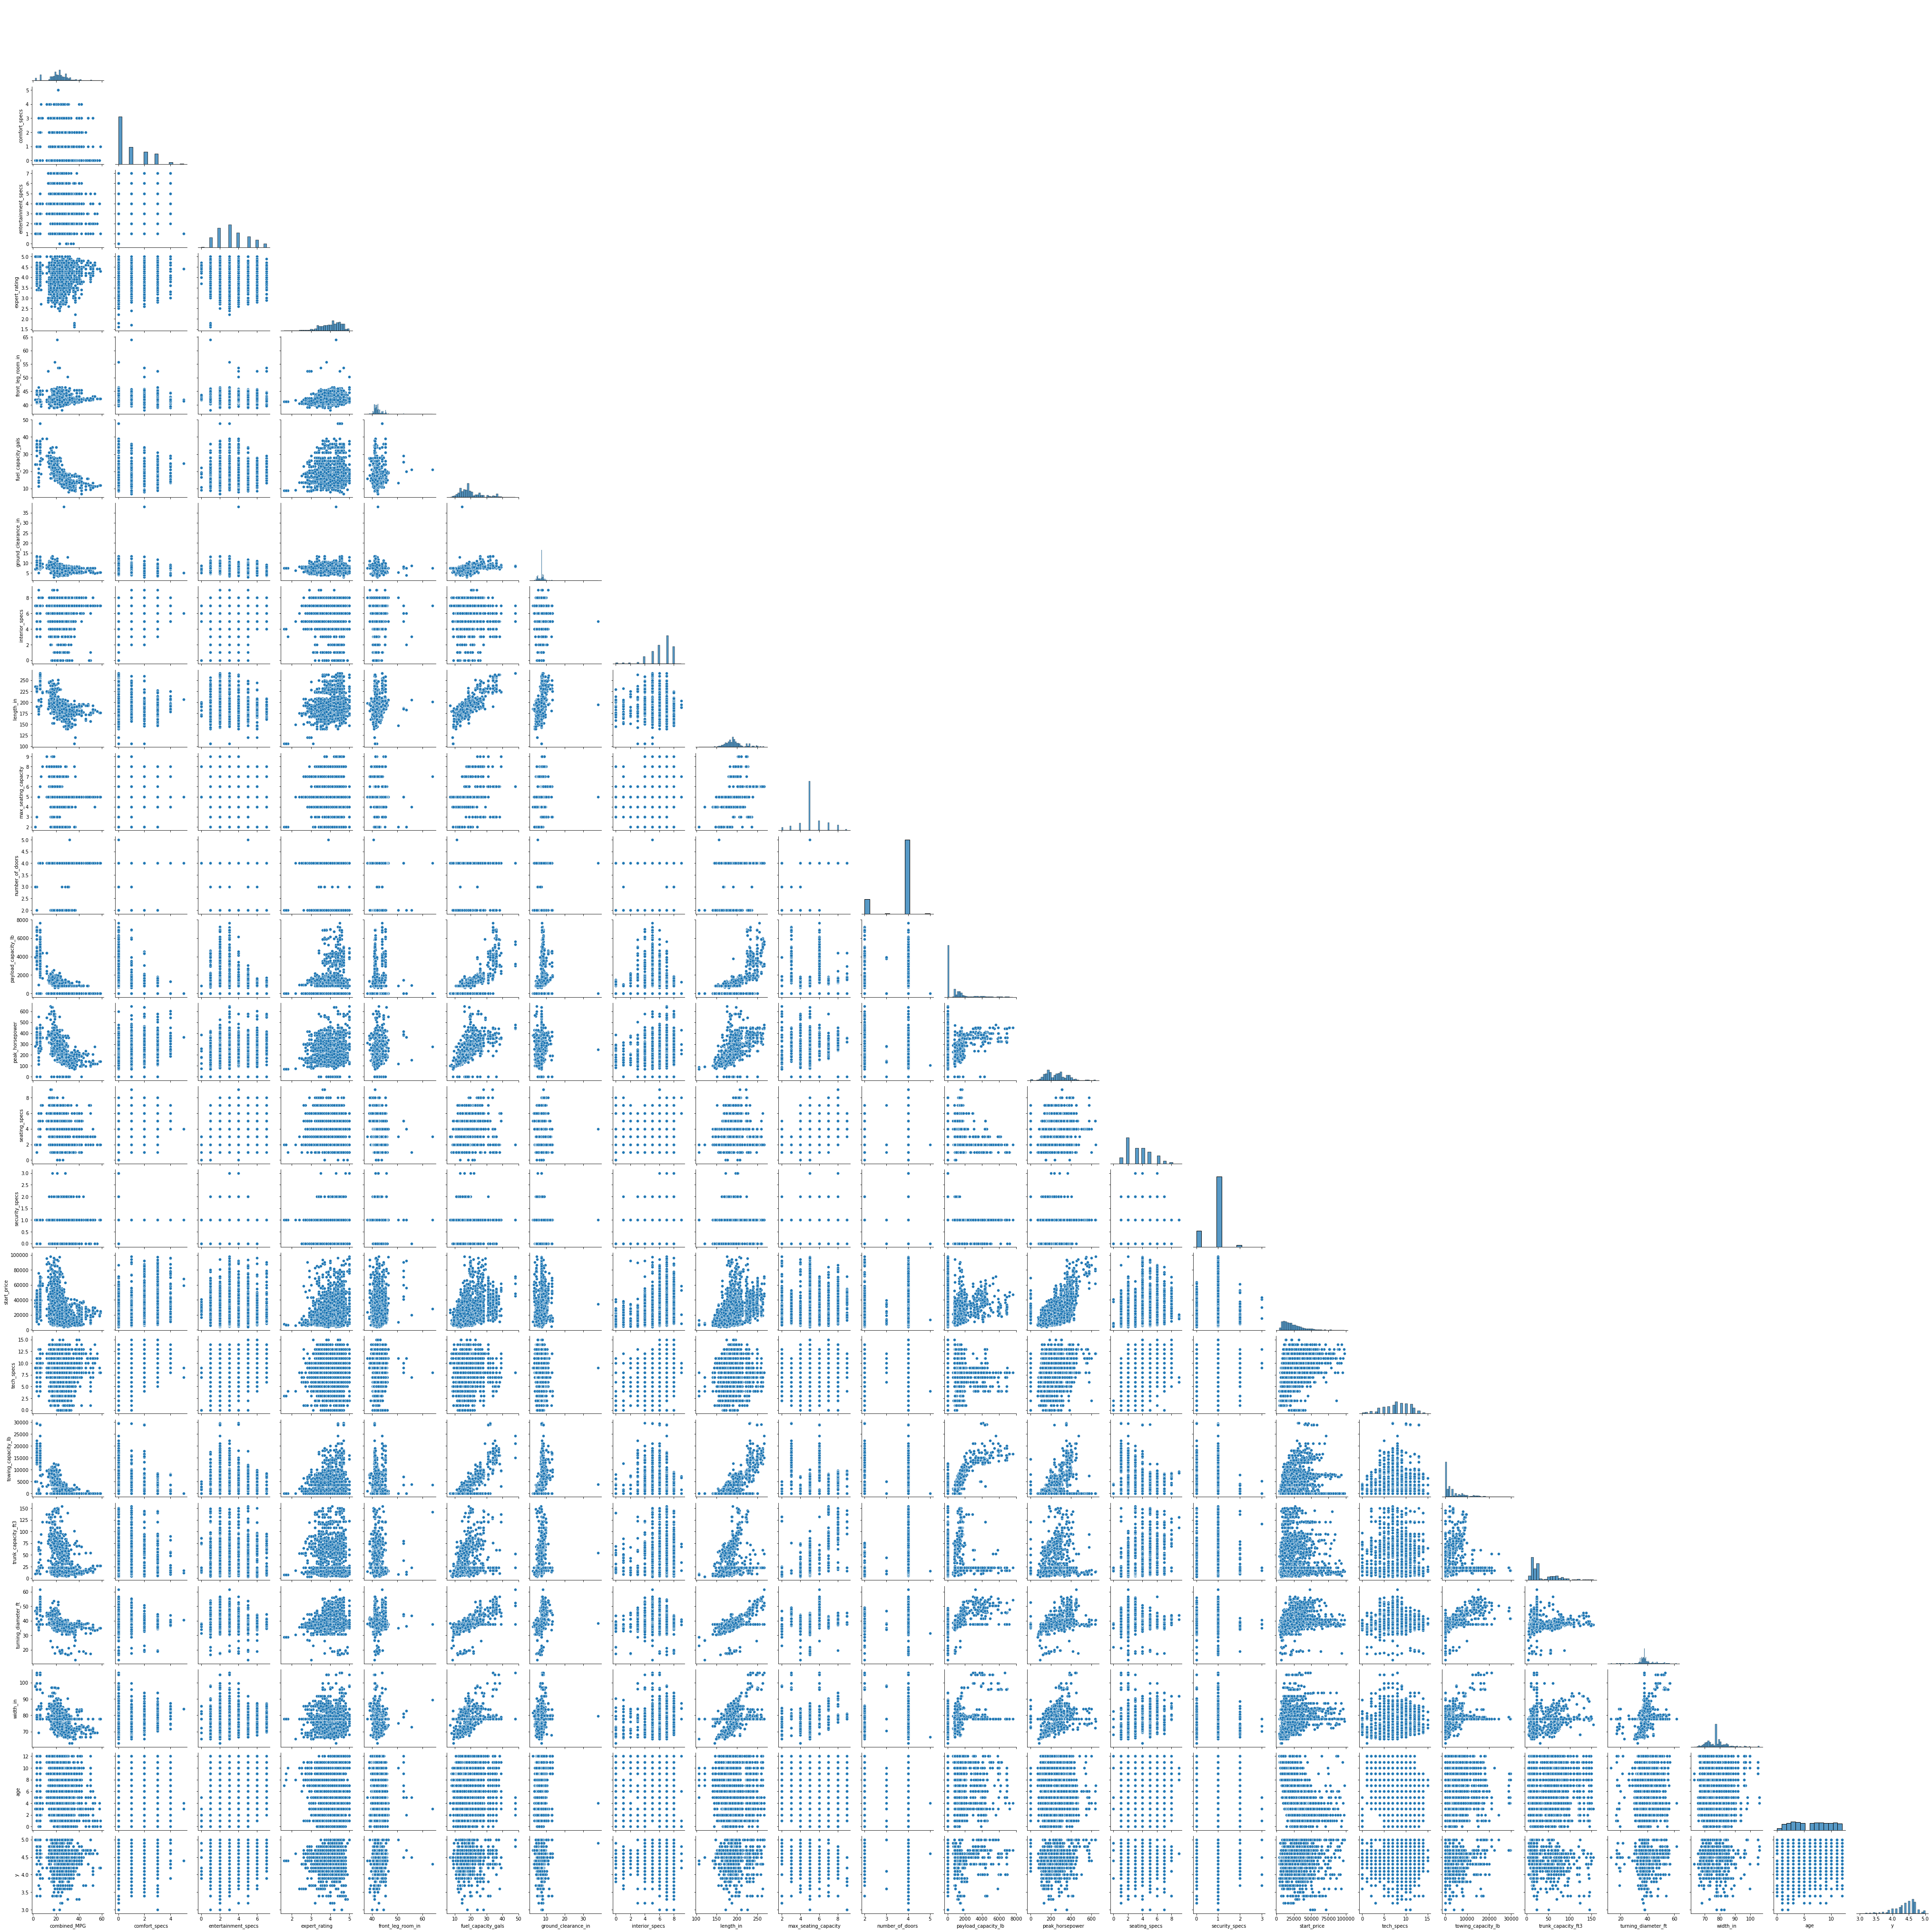

In [29]:
sns.pairplot(pairplot_train, corner=True)

<AxesSubplot:>

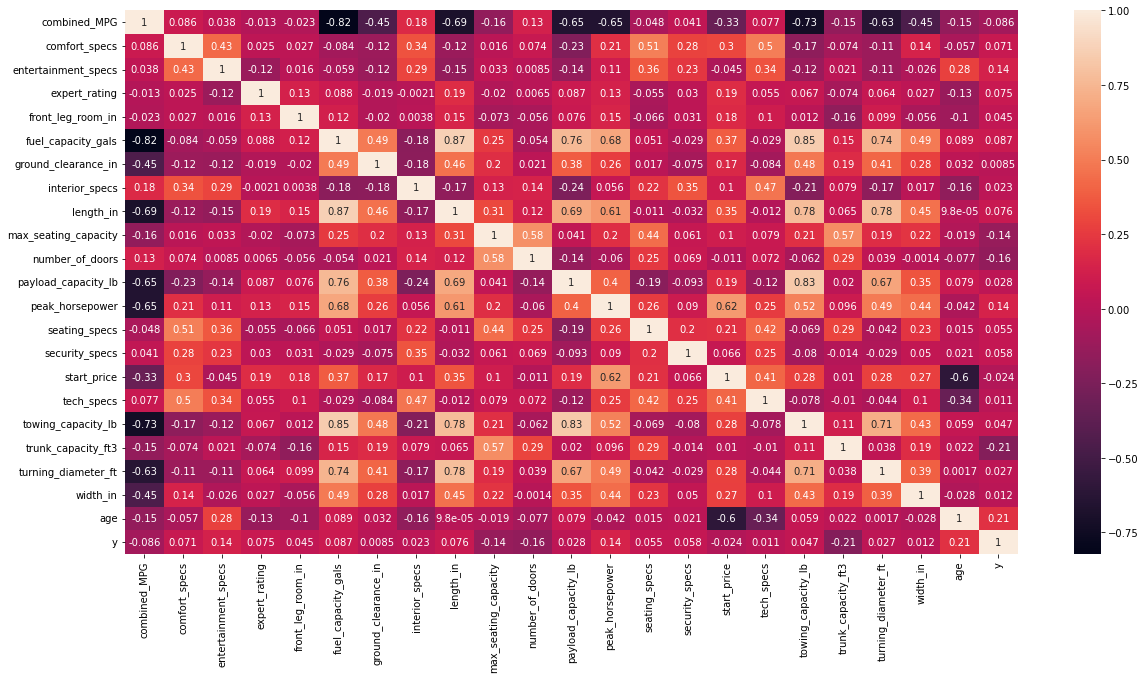

In [30]:
#looking for the same things, but with correlation coefficients
corrs = pairplot_train.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrs, cmap="rocket",annot=True, ax=ax)

Next, I want to get a sense of the importance of our dummy variable columns. We can do so by finding the average consumer rating of the rows that have a 1 in that column and compare it to the average consumer rating of rows with a zero. The difference between those two values is plotted below.

Text(0.5, 0, 'Column Name')

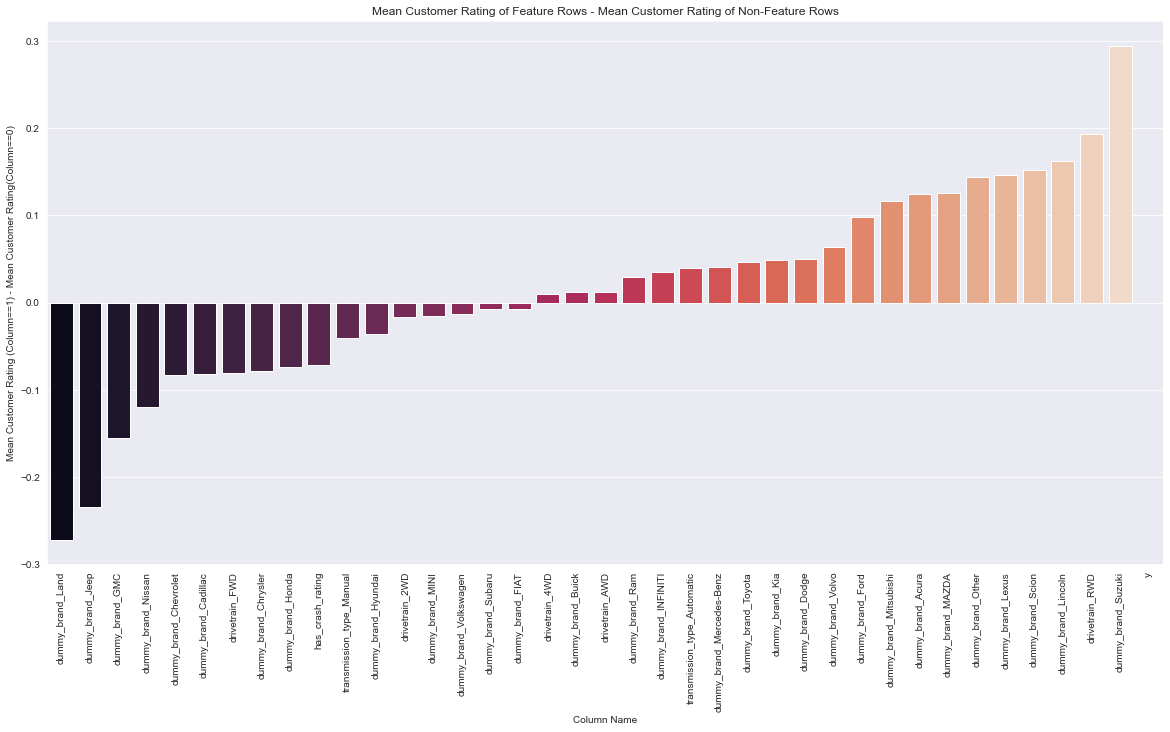

In [31]:
len(dummies.columns)

plt.rcParams.update({'figure.max_open_warning': 0})

differences = {}
for i, col in enumerate(dummies.columns):
    #get the mean for the rows with a 0
    false_mean = np.mean(dummies.y[dummies[col]==0])
    #get the mean for the rows with a 1
    true_mean = np.mean(dummies.y[dummies[col]==1])
    
    #take the difference
    difference_in_means = true_mean - false_mean
    
    #add the difference to a dict to plot
    differences[col] = difference_in_means
    
    
diffs = {k: v for k, v in sorted(differences.items(), key=lambda item: item[1])}

keys = list(diffs.keys())
vals = list(diffs.values())

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=keys, y=vals, ax=ax, palette="rocket")
ax.grid
ax.tick_params(axis='x', rotation=90)
ax.set_title('Mean Customer Rating of Feature Rows - Mean Customer Rating of Non-Feature Rows')
ax.set_ylabel('Mean Customer Rating (Column==1) - Mean Customer Rating(Column==0)')
ax.set_xlabel('Column Name')

We can also look at the distribution of our target variable to get a sense of our potential prediction range. Consumer reviews are (as seen below) pretty skewed to the top end of the spectrum. 

Text(0.5, 0, 'Consumer Rating')

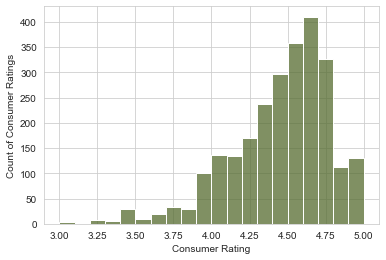

In [32]:
#plot distribution of target variable
x_train['consumer_rating'] = y_train
sns.set_style("whitegrid")
sns.histplot(x_train.consumer_rating, bins=20, color="darkolivegreen")
plt.ylabel('Count of Consumer Ratings')
plt.xlabel('Consumer Rating')

# Building Regression Models

## Defining Repeatable Functions

Now it's time to begin building, training, and iterating on some regression models. To start, I am going to write some functions that will be used repeatedly in the process to reduce the code and keep things organized. 

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, LinearRegression
import sklearn.metrics

In [34]:
#get the optimal alpha value for a lasso model 
def get_alpha_lasso(reg_x,y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)

    alpha = np.logspace(-4, 2, 100)
    param_grid = dict(alpha=alpha)
    lasso_model = LassoCV(alphas=alpha, cv=kf)
    lasso_model.fit(reg_x, y_train)
    best_alpha = lasso_model.alpha_
    return best_alpha

#get the optimal alpha value for a ridge model
def get_alpha_ridge(reg_x,y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)

    alpha = np.logspace(-4, 2, 100)
    param_grid = dict(alpha=alpha)
    ridge_model = RidgeCV(alphas=alpha, cv=kf)
    ridge_model.fit(reg_x, y_train)
    best_alpha = ridge_model.alpha_
    return best_alpha

#cross validate the model with 5 folds and output scores
def cross_validate(x, y, model, model_type):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)
    r2_scores = cross_val_score(model, x, y, cv=kf, scoring='r2')
    neg_mae_scores = cross_val_score(model, x, y, cv=kf, scoring='neg_mean_absolute_error')
    
    print('Model Name:', model_type)
    print('Cross-Validation R^2 Scores :', r2_scores)
    print('Average R^2 Score:', np.mean(r2_scores))
    print('Cross-Validation Neg MAE Scores:', neg_mae_scores)
    print('Average Neg MAE Score:', np.mean(neg_mae_scores))
    
#plot a graph of the cross validation predictions
def cross_val_graph(x,y,model,model_type):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)
    predictions = cross_val_predict(model, x,y, cv=kf)
    sns.jointplot(x=predictions,y=y, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
    
#plot a graph of the model's residuals
def plot_residuals(x,y,model,model_type):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)
    predictions = cross_val_predict(model, x,y, cv=kf)
    residuals = y - predictions
    sns.jointplot(x=predictions,y=residuals, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
    

## Baseline Model, All Features

In order to make informed decisions later, we'll start with a baseline simple regression model using all of the features at our disposal. 

In [35]:
baseline=LinearRegression()
baseline.fit(x_train_,y_train)
cross_validate(x_train_,y_train, baseline, "Simple Linear Regression")

Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.23044976 0.16801423 0.2805234  0.17267407 0.22673655]
Average R^2 Score: 0.21567960293015745
Cross-Validation Neg MAE Scores: [-0.21253551 -0.22353725 -0.21410029 -0.22528011 -0.22774061]
Average Neg MAE Score: -0.22063875418930173


## Using Lasso for Feature Selection

The Lasso model uses regularization to reduce complexity in the model by reducing less important features to have minimal to no coefficient in the model. We can use Lasso to look for features that are important to our target variable and filter out others. 

In [36]:
#first, scale all non-dummy numerical columns 

x_train_ = x_train_.reset_index().drop('index', axis=1)
x_test_ = x_test_.reset_index().drop('index', axis=1)

xtrain_ready_for_regular = x_train_[['combined_MPG', 'comfort_specs', 'entertainment_specs', 'expert_rating',
                             'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in', 'interior_specs',
                             'length_in', 'max_seating_capacity', 'number_of_doors', 'payload_capacity_lb', 'peak_horsepower',
                             'seating_specs', 'security_specs', 'start_price', 'tech_specs', 'towing_capacity_lb',
                             'trunk_capacity_ft3', 'turning_diameter_ft', 'width_in', 'age']]

dummies_xtrain = x_train_[x_train_.columns.difference(['combined_MPG', 'comfort_specs', 'entertainment_specs', 'expert_rating',
                             'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in', 'interior_specs',
                             'length_in', 'max_seating_capacity', 'number_of_doors', 'payload_capacity_lb', 'peak_horsepower',
                             'seating_specs', 'security_specs', 'start_price', 'tech_specs', 'towing_capacity_lb',
                             'trunk_capacity_ft3', 'turning_diameter_ft', 'width_in', 'age', 'brand', 'fuel_type','name'])]

xtest_ready_for_regular = x_test_[['combined_MPG', 'comfort_specs', 'entertainment_specs', 'expert_rating',
                             'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in', 'interior_specs',
                             'length_in', 'max_seating_capacity', 'number_of_doors', 'payload_capacity_lb', 'peak_horsepower',
                             'seating_specs', 'security_specs', 'start_price', 'tech_specs', 'towing_capacity_lb',
                             'trunk_capacity_ft3', 'turning_diameter_ft', 'width_in', 'age']]

dummies_xtest = x_test_[x_test_.columns.difference(['combined_MPG', 'comfort_specs', 'entertainment_specs', 'expert_rating',
                             'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in', 'interior_specs',
                             'length_in', 'max_seating_capacity', 'number_of_doors', 'payload_capacity_lb', 'peak_horsepower',
                             'seating_specs', 'security_specs', 'start_price', 'tech_specs', 'towing_capacity_lb',
                             'trunk_capacity_ft3', 'turning_diameter_ft', 'width_in', 'age', 'brand', 'fuel_type','name'])]




std = StandardScaler()
std.fit(xtrain_ready_for_regular)

xtrain_reg = std.transform(xtrain_ready_for_regular.values)
xtest_reg = std.transform(xtest_ready_for_regular.values)

In [37]:
#create dataframes of regularized values
xtrain_reg = pd.DataFrame(xtrain_reg, columns=xtrain_ready_for_regular.columns)
xtest_reg = pd.DataFrame(xtest_reg, columns=xtest_ready_for_regular.columns)


In [38]:
#add dummies to those dataframes
regular_xtrain = pd.concat([xtrain_reg, dummies_xtrain], axis=1)
regular_xtest = pd.concat([xtest_reg, dummies_xtest], axis=1)

Model Name: Lasso
Cross-Validation R^2 Scores : [0.23874664 0.17606605 0.27109609 0.1763766  0.22429667]
Average R^2 Score: 0.21731640829291834
Cross-Validation Neg MAE Scores: [-0.21147487 -0.22212546 -0.21572    -0.22489684 -0.2280327 ]
Average Neg MAE Score: -0.22044997368952943


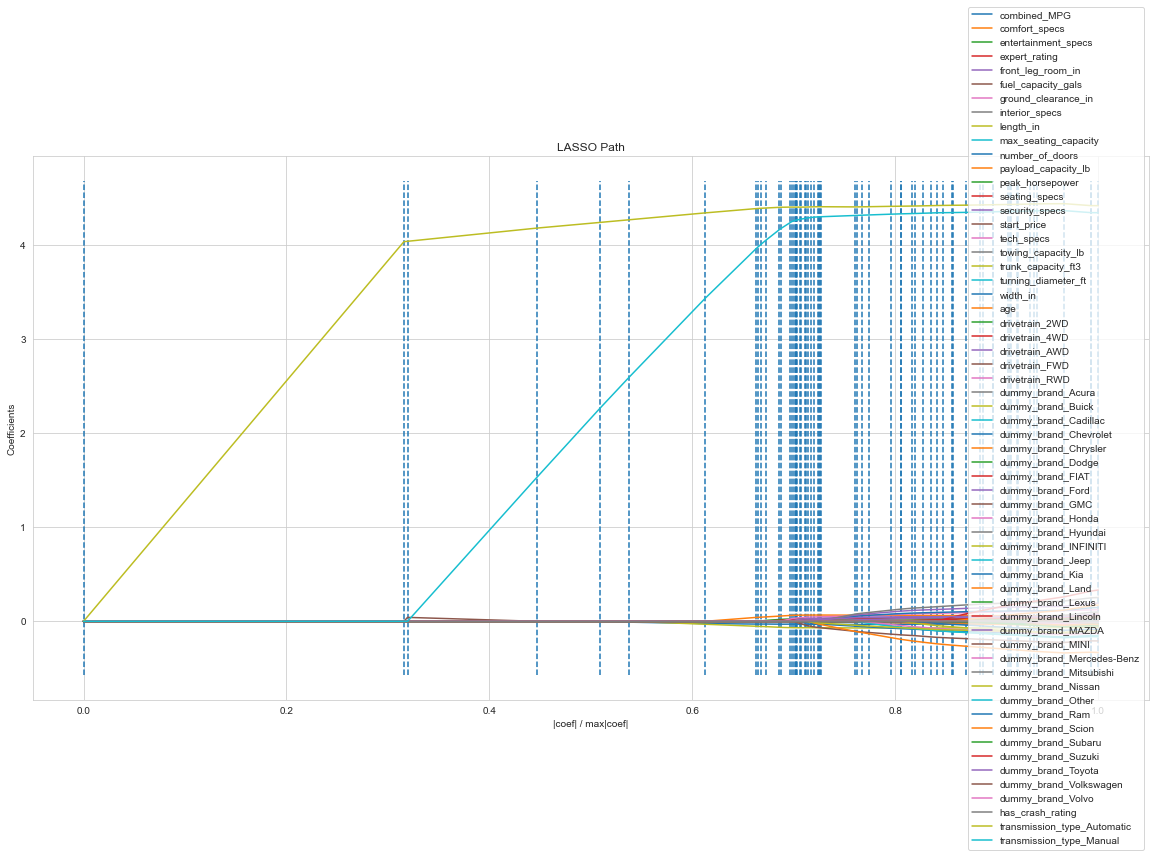

In [39]:
#iteration 1 of lasso/lars path feature selection

lasso_alpha = get_alpha_lasso(regular_xtrain, y_train)
lasso_lr = Lasso(alpha=lasso_alpha)
lasso_lr.fit(regular_xtrain, y_train)
cross_validate(regular_xtrain, y_train, lasso_lr, "Lasso")
#first lars path iteration

from sklearn.linear_model import lars_path

regular_xtrain_np = regular_xtrain.to_numpy()
alphas, _, coefs = lars_path(regular_xtrain_np, y_train.values, method='lasso')

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(20,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(regular_xtrain.columns,loc= 'right')
plt.show()

In [40]:
#which features did the lars path squash? print those values
coefs = lasso_lr.coef_
importance = np.abs(coefs)
not_important = list(np.array(regular_xtrain.columns)[importance == 0])
print(not_important)
#remove these from train and test
x_train_ = x_train_[x_train_.columns.difference(not_important)]
x_test_ = x_test_[x_test_.columns.difference(not_important)]
regular_xtrain = regular_xtrain[regular_xtrain.columns.difference(not_important)]
regular_xtest = regular_xtest[regular_xtest.columns.difference(not_important)]



['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual']


Model Name: Lasso
Cross-Validation R^2 Scores : [0.23996142 0.17680235 0.27119628 0.17706906 0.22547238]
Average R^2 Score: 0.2181002949556147
Cross-Validation Neg MAE Scores: [-0.21139556 -0.2219045  -0.21572204 -0.22460348 -0.22799889]
Average Neg MAE Score: -0.22032489525308935


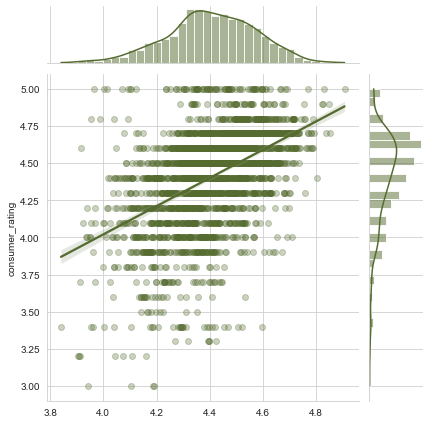

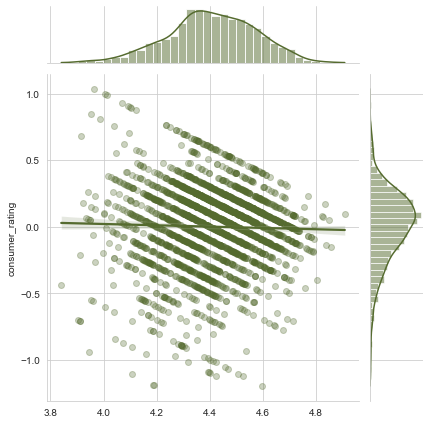

In [41]:
#iteration 2 of lasso/lars path feature selection

lasso_alpha2 = get_alpha_lasso(regular_xtrain, y_train)
lasso_lr2 = Lasso(alpha=lasso_alpha)
lasso_lr2.fit(regular_xtrain, y_train)
cross_validate(regular_xtrain, y_train, lasso_lr2, "Lasso")
cross_val_graph(regular_xtrain,y_train,lasso_lr2, "Lasso")
plot_residuals(regular_xtrain,y_train,lasso_lr2, "Lasso")

In [42]:
#which features did the lars path squash?
coefs = lasso_lr2.coef_
importance = np.abs(coefs)
not_important = list(np.array(regular_xtrain.columns)[importance == 0])
not_important
#it didn't squash any. let's move on with these features to figure out what kind of
#model will work best 

[]

## Choosing Model Type

There are a number of regression models that could work for this problem. I'll be experimenting with a simple linear regression (used as our baseline), a Lasso (used above), and a Ridge model. The model with the best interpretability (without a huge loss in performance) will be our final choice.

In [43]:
lasso_a = get_alpha_lasso(regular_xtrain, y_train)
ridge_a = get_alpha_ridge(regular_xtrain, y_train)

lasso_reg = Lasso(alpha=lasso_a)
lasso_reg.fit(regular_xtrain, y_train)
cross_validate(regular_xtrain, y_train, lasso_reg, "Lasso")
print('\n')

ridge_reg = Ridge(alpha=ridge_a)
ridge_reg.fit(regular_xtrain, y_train)
cross_validate(regular_xtrain, y_train, ridge_reg, "Ridge")
print('\n')

simple_reg = LinearRegression()
simple_reg.fit(x_train_, y_train)
cross_validate(x_train_, y_train, simple_reg, "Simple Linear Regression")

Model Name: Lasso
Cross-Validation R^2 Scores : [0.2366614  0.17397317 0.27642225 0.17627817 0.22808798]
Average R^2 Score: 0.21828459229381494
Cross-Validation Neg MAE Scores: [-0.21171785 -0.22238519 -0.21497275 -0.22455868 -0.22773951]
Average Neg MAE Score: -0.22027479514378787


Model Name: Ridge
Cross-Validation R^2 Scores : [0.23930524 0.17527244 0.27643205 0.1783056  0.22531973]
Average R^2 Score: 0.21892701197422476
Cross-Validation Neg MAE Scores: [-0.2113114  -0.2224154  -0.21504881 -0.22430325 -0.22822164]
Average Neg MAE Score: -0.2202601018833552


Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.23206163 0.1701997  0.28134968 0.17398356 0.22990998]
Average R^2 Score: 0.2175009096562089
Cross-Validation Neg MAE Scores: [-0.21241335 -0.22296993 -0.21426515 -0.22476119 -0.22766218]
Average Neg MAE Score: -0.22041435814118268


## Feature Engineering 

In an attempt to improve performance, we can engineer some features that may help with prediction. In addition, we can remove some columns that don't seem to be helping the models. The below code is the outcome of iterations of different feature combinations.

In [44]:
x_train2 = x_train_[x_train_.columns.difference(['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 
                                                 'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual'])]
regular_xtrain2 = regular_xtrain[regular_xtrain.columns.difference(['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 
                   'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual'])]

regular_xtest2 = regular_xtest[regular_xtest.columns.difference(['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 
                   'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual'])]
x_test2 = x_test_[x_test_.columns.difference(['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 
                   'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual'])]


In [45]:
# affect of removing squashed columns
lasso_a = get_alpha_lasso(regular_xtrain2, y_train)
ridge_a = get_alpha_ridge(regular_xtrain2, y_train)

lasso_reg = Lasso(alpha=lasso_a)
lasso_reg.fit(regular_xtrain2, y_train)
cross_validate(regular_xtrain2, y_train, lasso_reg, "Lasso")
print('\n')

ridge_reg = Ridge(alpha=ridge_a)
ridge_reg.fit(regular_xtrain2, y_train)
cross_validate(regular_xtrain2, y_train, ridge_reg, "Ridge")
print('\n')

simple_reg = LinearRegression()
simple_reg.fit(x_train2, y_train)
cross_validate(x_train2, y_train, simple_reg, "Simple Linear Regression")

Model Name: Lasso
Cross-Validation R^2 Scores : [0.2366614  0.17397317 0.27642225 0.17627817 0.22808798]
Average R^2 Score: 0.21828459229381494
Cross-Validation Neg MAE Scores: [-0.21171785 -0.22238519 -0.21497275 -0.22455868 -0.22773951]
Average Neg MAE Score: -0.22027479514378787


Model Name: Ridge
Cross-Validation R^2 Scores : [0.23930524 0.17527244 0.27643205 0.1783056  0.22531973]
Average R^2 Score: 0.21892701197422476
Cross-Validation Neg MAE Scores: [-0.2113114  -0.2224154  -0.21504881 -0.22430325 -0.22822164]
Average Neg MAE Score: -0.2202601018833552


Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.23206163 0.1701997  0.28134968 0.17398356 0.22990998]
Average R^2 Score: 0.2175009096562089
Cross-Validation Neg MAE Scores: [-0.21241335 -0.22296993 -0.21426515 -0.22476119 -0.22766218]
Average Neg MAE Score: -0.22041435814118268


In [47]:
##increased r^2 by ~.01, MAE down by .0005
x_train2['combined_MPG_2'] = x_train2.combined_MPG ** 2
regular_xtrain2['combined_MPG_2'] = regular_xtrain2.combined_MPG ** 2
regular_xtest2['combined_MPG_2'] = regular_xtest2.combined_MPG **2 
x_test2['combined_MPG_2'] = x_test2.combined_MPG **2

#increased r^2 by .004, mae down by .0004
x_train2['entertainment_specs_2'] = x_train2.entertainment_specs **2
regular_xtrain2['entertainment_specs_2'] = regular_xtrain2.entertainment_specs **2
regular_xtest2['entertainment_specs_2'] = regular_xtest2.entertainment_specs **2 
x_test2['entertainment_specs_2'] = x_test2.entertainment_specs**2


In [48]:
# try the models with each new feature 
lasso_a = get_alpha_lasso(regular_xtrain2, y_train)
ridge_a = get_alpha_ridge(regular_xtrain2, y_train)

lasso_reg = Lasso(alpha=lasso_a)
lasso_reg.fit(regular_xtrain2, y_train)
cross_validate(regular_xtrain2, y_train, lasso_reg, "Lasso")
print('\n')

ridge_reg = Ridge(alpha=ridge_a)
ridge_reg.fit(regular_xtrain2, y_train)
cross_validate(regular_xtrain2, y_train, ridge_reg, "Ridge")
print('\n')

simple_reg = LinearRegression()
simple_reg.fit(x_train2, y_train)
cross_validate(x_train2, y_train, simple_reg, "Simple Linear Regression")

Model Name: Lasso
Cross-Validation R^2 Scores : [0.25630334 0.19480794 0.2719622  0.18768232 0.24140986]
Average R^2 Score: 0.23043313118396364
Cross-Validation Neg MAE Scores: [-0.21064582 -0.21963789 -0.21648769 -0.2229614  -0.22677142]
Average Neg MAE Score: -0.21930084609771622


Model Name: Ridge
Cross-Validation R^2 Scores : [0.25760126 0.1946328  0.27194705 0.18934732 0.23955793]
Average R^2 Score: 0.2306172726943183
Cross-Validation Neg MAE Scores: [-0.21034279 -0.21983071 -0.21655252 -0.22263358 -0.22710167]
Average Neg MAE Score: -0.219292254148358


Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.25102165 0.19035428 0.27662052 0.18459316 0.2438514 ]
Average R^2 Score: 0.22928820022776727
Cross-Validation Neg MAE Scores: [-0.21137005 -0.22032669 -0.21564133 -0.22330863 -0.22642496]
Average Neg MAE Score: -0.21941433178623768


## Addressing Multicollinearity

As mentioned above, if features are strongly related to each other, they can introduce instability into our model. There's no need to include two features that are saying a very simliar thing. Below we'll use the VIF - Variance Inflation Factor - to determine which features are causing multicollinearity and remove them. 

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#use VIF to find the columns that are causing multicollinearity

x_train3 = x_train2.copy()
regular_xtrain3 = regular_xtrain2.copy()
regular_xtest3 = regular_xtest2.copy()
x_test3 = x_test2.copy()
def vif(df_x):
    '''
    Calculate the VIF for each feature of df_x (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_x.values, i)
                for i in range(df_x.shape[1])]
    
    return pd.Series(vif_data, index=df_x.columns)   

vif(x_train3)                                    

age                             14.206441
combined_MPG                   202.685596
comfort_specs                    4.395693
drivetrain_2WD                   2.759693
drivetrain_AWD                   3.548832
drivetrain_FWD                  10.643884
drivetrain_RWD                   4.157644
dummy_brand_Acura                1.338217
dummy_brand_Buick                1.263340
dummy_brand_Cadillac             1.503076
dummy_brand_Chevrolet            2.292757
dummy_brand_Chrysler             1.223558
dummy_brand_Dodge                1.370595
dummy_brand_FIAT                 1.228519
dummy_brand_Ford                 2.410517
dummy_brand_GMC                  2.054962
dummy_brand_Hyundai              1.531816
dummy_brand_INFINITI             1.390133
dummy_brand_Jeep                 1.500473
dummy_brand_Kia                  1.449659
dummy_brand_Land                 1.597361
dummy_brand_Lexus                1.589361
dummy_brand_Lincoln              1.484978
dummy_brand_MAZDA                1

In [50]:
#the following column removals are the outcome of iterations based on the VIF
#results above
x_train3 = x_train3[x_train3.columns.difference(['length_in','width_in','turning_diameter_ft','tech_specs',
                                                 'interior_specs','start_price','towing_capacity_lb','comfort_specs',
                                                 'drivetrain_2WD','drivetrain_FWD','dummy_brand_Acura', 'dummy_brand_Buick'
                                                 ,'dummy_brand_Chrysler','dummy_brand_FIAT','dummy_brand_Ford'
                                                ,'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_Toyota'
                                                ,'dummy_brand_Volvo','has_crash_rating','security_specs'])] 
                                           
regular_xtrain3 = regular_xtrain3[regular_xtrain3.columns.difference(['length_in','width_in', 'turning_diameter_ft',
                                                                     'tech_specs','interior_specs','start_price',
                                                                      'towing_capacity_lb','comfort_specs','drivetrain_2WD'
                                                                      ,'drivetrain_FWD','dummy_brand_Acura','dummy_brand_Buick'
                                                                      ,'dummy_brand_Chrysler','dummy_brand_FIAT','dummy_brand_Ford'
                                                                    ,'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_Toyota'
                                                                     ,'dummy_brand_Volvo','has_crash_rating','security_specs'])]

regular_xtest3 = regular_xtest3[regular_xtrain3.columns.difference(['length_in','width_in', 'turning_diameter_ft',
                                                                     'tech_specs','interior_specs','start_price',
                                                                      'towing_capacity_lb','comfort_specs','drivetrain_2WD'
                                                                      ,'drivetrain_FWD','dummy_brand_Acura','dummy_brand_Buick'
                                                                      ,'dummy_brand_Chrysler','dummy_brand_FIAT','dummy_brand_Ford'
                                                                    ,'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_Toyota'
                                                                     ,'dummy_brand_Volvo','has_crash_rating','security_specs'])]

x_test3 = x_test3[x_test3.columns.difference(['length_in','width_in', 'turning_diameter_ft',
                                                                     'tech_specs','interior_specs','start_price',
                                                                      'towing_capacity_lb','comfort_specs','drivetrain_2WD'
                                                                      ,'drivetrain_FWD','dummy_brand_Acura','dummy_brand_Buick'
                                                                      ,'dummy_brand_Chrysler','dummy_brand_FIAT','dummy_brand_Ford'
                                                                    ,'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_Toyota'
                                                                     ,'dummy_brand_Volvo','has_crash_rating','security_specs'])]


vif(x_train3)

age                              5.536274
combined_MPG                   123.635209
combined_MPG_2                  35.311872
drivetrain_AWD                   1.566608
drivetrain_RWD                   1.841249
dummy_brand_Cadillac             1.150840
dummy_brand_Chevrolet            1.385057
dummy_brand_Dodge                1.118106
dummy_brand_GMC                  1.381385
dummy_brand_Hyundai              1.172018
dummy_brand_INFINITI             1.180430
dummy_brand_Jeep                 1.119367
dummy_brand_Kia                  1.170697
dummy_brand_Land                 1.138937
dummy_brand_MAZDA                1.135968
dummy_brand_Mercedes-Benz        1.679857
dummy_brand_Mitsubishi           1.100199
dummy_brand_Nissan               1.217664
dummy_brand_Ram                  1.373097
dummy_brand_Scion                1.074277
dummy_brand_Suzuki               1.063605
entertainment_specs            101.642852
entertainment_specs_2           42.258500
expert_rating                   62

Model Name: Lasso
Cross-Validation R^2 Scores : [0.25941828 0.21497773 0.27304516 0.19941038 0.25145961]
Average R^2 Score: 0.2396622313731414
Cross-Validation Neg MAE Scores: [-0.21182446 -0.21620035 -0.21644039 -0.22092087 -0.22480818]
Average Neg MAE Score: -0.21803884987398608


Model Name: Ridge
Cross-Validation R^2 Scores : [0.26110373 0.21731538 0.2727494  0.20090142 0.24924382]
Average R^2 Score: 0.2402627514345732
Cross-Validation Neg MAE Scores: [-0.21137519 -0.215979   -0.21660521 -0.22081907 -0.22513518]
Average Neg MAE Score: -0.2179827314942194


Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.25755983 0.21396222 0.27426728 0.19905425 0.25322336]
Average R^2 Score: 0.2396133871915839
Cross-Validation Neg MAE Scores: [-0.21223641 -0.21624597 -0.21617523 -0.22089811 -0.22461036]
Average Neg MAE Score: -0.21803321649147267


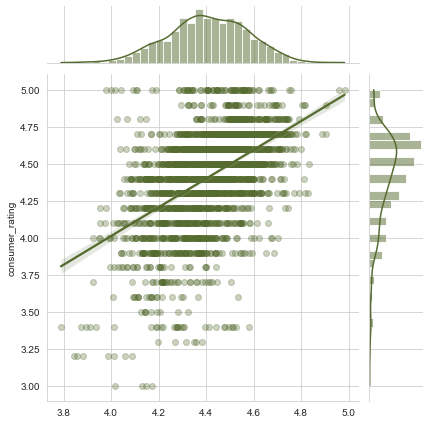

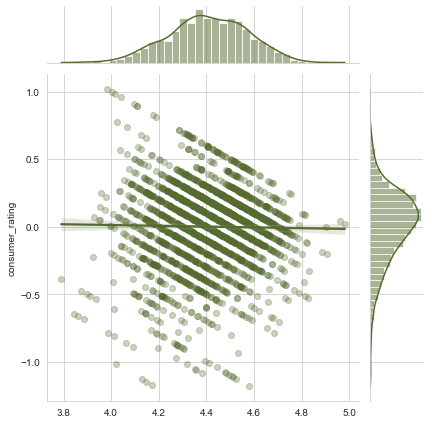

In [51]:
#attempt another model post-VIF analysis

lasso_a = get_alpha_lasso(regular_xtrain3, y_train)
ridge_a = get_alpha_ridge(regular_xtrain3, y_train)

lasso_reg_f = Lasso(alpha=lasso_a)
lasso_reg_f.fit(regular_xtrain3, y_train)
cross_validate(regular_xtrain3, y_train, lasso_reg_f, "Lasso")
#cross_val_graph(regular_xtrain3,y_train,lasso_reg, "Lasso")
print('\n')

ridge_reg_f = Ridge(alpha=ridge_a)
ridge_reg_f.fit(regular_xtrain3, y_train)
cross_validate(regular_xtrain3, y_train, ridge_reg_f, "Ridge")
cross_val_graph(regular_xtrain3,y_train,ridge_reg_f, "Ridge")
plot_residuals(regular_xtrain3,y_train,ridge_reg_f, "Ridge")
print('\n')

simple_reg_f = LinearRegression()
simple_reg_f.fit(x_train3, y_train)
cross_validate(x_train3, y_train, simple_reg_f, "Simple Linear Regression")
#cross_val_graph(regular_xtrain,y_train,simple_reg, "Simple Linear Regression")

The best performing model is the Ridge Model. Since our goal is interpretabliity, we can take a look at which features are factoring in most heavily. 

In [52]:
print('Feature coefficient results for the most recent Ridge model:')
for feature, coef in zip(regular_xtrain3.columns, ridge_reg_f.coef_):
    print(feature, ':', f'{coef:.2f}')

Feature coefficient results for the most recent Ridge model:
age : 0.06
combined_MPG : -0.03
combined_MPG_2 : 0.02
drivetrain_AWD : 0.05
drivetrain_RWD : 0.11
dummy_brand_Cadillac : -0.20
dummy_brand_Chevrolet : -0.15
dummy_brand_Dodge : -0.08
dummy_brand_GMC : -0.24
dummy_brand_Hyundai : -0.05
dummy_brand_INFINITI : -0.18
dummy_brand_Jeep : -0.18
dummy_brand_Kia : 0.10
dummy_brand_Land : -0.37
dummy_brand_MAZDA : 0.15
dummy_brand_Mercedes-Benz : -0.19
dummy_brand_Mitsubishi : 0.18
dummy_brand_Nissan : -0.14
dummy_brand_Ram : -0.14
dummy_brand_Scion : 0.10
dummy_brand_Suzuki : 0.20
entertainment_specs : 0.01
entertainment_specs_2 : 0.02
expert_rating : 0.02
fuel_capacity_gals : 0.04
ground_clearance_in : 0.03
max_seating_capacity : -0.02
number_of_doors : -0.02
payload_capacity_lb : -0.05
peak_horsepower : 0.04
seating_specs : 0.04
transmission_type_Automatic : 0.07
trunk_capacity_ft3 : -0.07


## Final Test on Holdout Set

Now that we've completed feature engineering & training to the best of our ability, we can finally test the model on our holdout set, which has not been touched since splitting the data at the beginning. We'll test all three models to see which performs best.

Final Ridge Regression R^2: 0.21834473649635033
Final Ridge Regression MAE: 0.23034418397654438


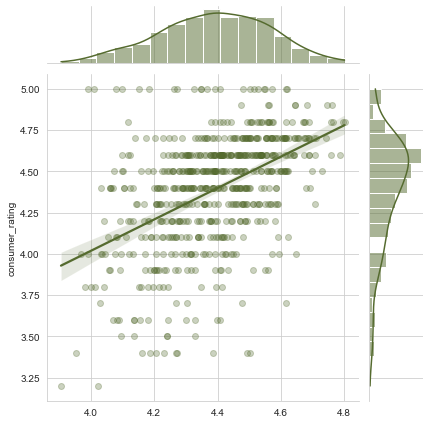

In [53]:
from sklearn.metrics import mean_absolute_error
#ridge model
ridge_reg_f.fit(regular_xtrain3, y_train)
ridge_preds = ridge_reg_f.predict(regular_xtest3)
print('Final Ridge Regression R^2:', ridge_reg_f.score(regular_xtest3, y_test))
print('Final Ridge Regression MAE:', mean_absolute_error(y_test, ridge_preds))


sns.jointplot(x=ridge_preds,y=y_test, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
    

Final Lasso Regression R^2: 0.21864953769857975
Final Lasso Regression MAE: 0.23031774271080646


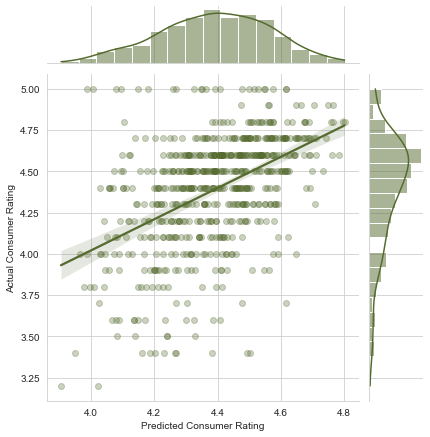

In [54]:
#lasso model
lasso_reg_f.fit(regular_xtrain3, y_train)
lasso_preds = lasso_reg_f.predict(regular_xtest3)
print('Final Lasso Regression R^2:', lasso_reg_f.score(regular_xtest3, y_test))
print('Final Lasso Regression MAE:', mean_absolute_error(y_test,lasso_preds))


plot=sns.jointplot(x=lasso_preds,y=y_test, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
plot.set_axis_labels('Predicted Consumer Rating', 'Actual Consumer Rating', fontsize=10)


Final Simple Regression R^2: 0.21883261857448366
Final Simple Regression MAE: 0.23015360814486102


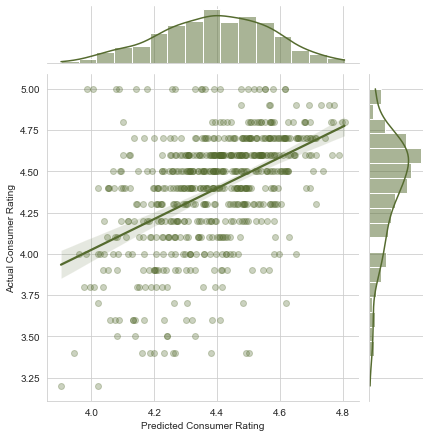

In [55]:
#simple model
simple_reg_f.fit(x_train3, y_train)
simple_preds = simple_reg_f.predict(x_test3)
print('Final Simple Regression R^2:', simple_reg_f.score(x_test3, y_test))
print('Final Simple Regression MAE:', mean_absolute_error(y_test,simple_preds))


plot = sns.jointplot(x=simple_preds,y=y_test, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
plot.set_axis_labels('Predicted Consumer Rating', 'Actual Consumer Rating', fontsize=10)


All three models are performing very similarly. For the sake of interpretability & simplicity, we'll move forward with the Lasso model. 

In [56]:
#these will be the coefficients for the Lasso model
coef_dict={}
for feature, coef in zip(regular_xtrain3.columns, lasso_reg_f.coef_):
    coef_dict[feature]=coef
    print(feature, ':', f'{coef:.5f}')

age : 0.06294
combined_MPG : -0.03116
combined_MPG_2 : 0.02442
drivetrain_AWD : 0.04614
drivetrain_RWD : 0.10922
dummy_brand_Cadillac : -0.20529
dummy_brand_Chevrolet : -0.15527
dummy_brand_Dodge : -0.07822
dummy_brand_GMC : -0.24470
dummy_brand_Hyundai : -0.05240
dummy_brand_INFINITI : -0.18407
dummy_brand_Jeep : -0.18890
dummy_brand_Kia : 0.09492
dummy_brand_Land : -0.38312
dummy_brand_MAZDA : 0.14940
dummy_brand_Mercedes-Benz : -0.19519
dummy_brand_Mitsubishi : 0.17921
dummy_brand_Nissan : -0.13947
dummy_brand_Ram : -0.14160
dummy_brand_Scion : 0.10015
dummy_brand_Suzuki : 0.22386
entertainment_specs : 0.01132
entertainment_specs_2 : 0.01870
expert_rating : 0.01841
fuel_capacity_gals : 0.04457
ground_clearance_in : 0.02551
max_seating_capacity : -0.02459
number_of_doors : -0.02405
payload_capacity_lb : -0.05015
peak_horsepower : 0.03536
seating_specs : 0.04286
transmission_type_Automatic : 0.06879
trunk_capacity_ft3 : -0.06538


Text(0, 0.5, 'Lasso Regression Coefficient')

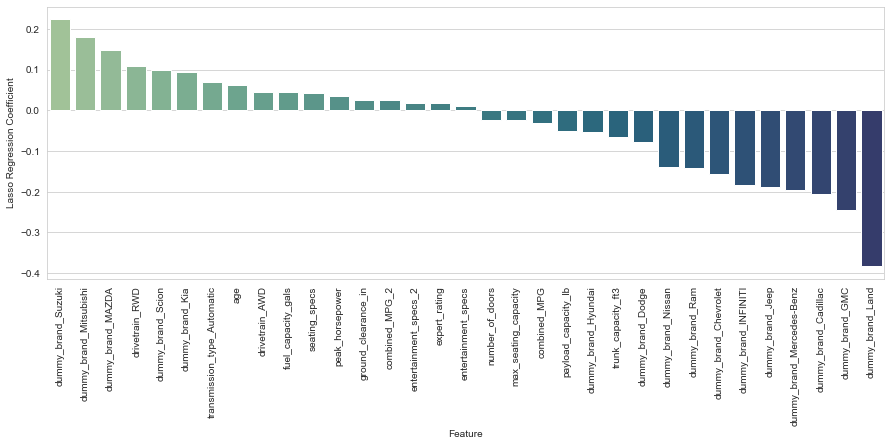

In [57]:
#plot the Lasso coefficients to show their importance
coef_plot = {k: v for k, v in sorted(coef_dict.items(), reverse=True, key=lambda item: item[1])}
plt.figure(figsize=(15,5))
sns.barplot(list(coef_plot.keys()), list(coef_plot.values()), palette="crest")
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Lasso Regression Coefficient')


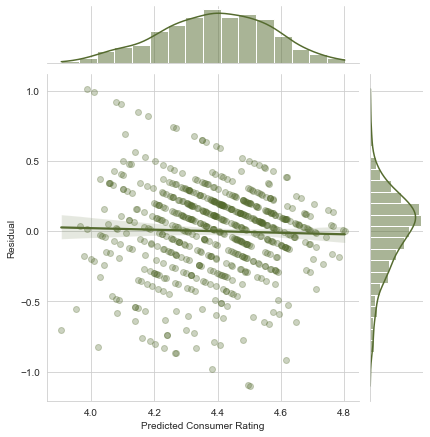

In [58]:
#plot the lasso residuals for project appendix
lasso_residuals = y_test - lasso_preds
plot=sns.jointplot(x=lasso_preds,y=lasso_residuals, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
plot.set_axis_labels('Predicted Consumer Rating', 'Residual', fontsize=10)


# Concluding Remarks

Through this regression model, we were able to achieve some of the interpretability that we set out to achieve. Though the model doesn't have strong predictive power, we can pull out some interesting insights about which features may impact consumer ratings. 

Certain brands, such as Suzuki and Mitsubishi, were predictive of positive reviews, while others like Land Rover and GMC predicted negative ratings. This could be an interesting opportunity for brand-specific research to understand consumers' preferences & expectations for those brands. Certain features, such as fuel capacity, horsepower, and seating, were also predictive of positive reviews. These could be more heavily included in new EV models. 

Digging in deeper to some of these insights could provide an interesting and productive path forward in EV manufacturing. 